<a href="https://colab.research.google.com/github/erados/Quantum-Computing/blob/main/cirq%2Btensorflow_to_optimize_QAOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow==2.3.1
!pip install -q tensorflow-quantum
!pip install -q cirq

     |████████████████████████████████| 320.4MB 46kB/s 
     |████████████████████████████████| 460kB 55.8MB/s 
     |████████████████████████████████| 20.1MB 10.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 5.9MB 6.4MB/s 
     |████████████████████████████████| 1.6MB 40.3MB/s 
     |████████████████████████████████| 5.6MB 23.4MB/s 


In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import tensorflow as tf
import tensorflow_quantum as tfq
import sympy
import csv
from cirq.contrib.svg import SVGCircuit
 
weight_upper_bound = 3
qubits_s = []
gammas_s = []
betas_s = []
graphs = []

ps = [3, 3, 3, 3]
n_graph = 4 # barbell, random, caveman, ladder
graph_types = ['barbell', 'random', 'caveman', 'ladder']
num_nodes = [10, 10, 10, 10]


# ps = [10]
# n_graph = 1 # barbell, random, caveman, ladder
# graph_types = ['random']
# num_nodes = [10]
 
 
def create_graph(type, num_nodes, probability = 0.5, seed = 0, weight = False):
  even_num_nodes = int(num_nodes/2)
  if type == "random":
    G = nx.erdos_renyi_graph(even_num_nodes * 2, probability, seed=seed)
  elif type == "barbell":
    G = nx.barbell_graph(even_num_nodes, 0)
  elif type == "ladder":
    G = nx.ladder_graph(even_num_nodes)
  elif type == "caveman": 
    G = nx.connected_caveman_graph(2, even_num_nodes)
  else:
    print("No such graph type.")
    return
  for u,v in G.edges():
    if(weight == True):
      G[u][v]['weight'] =  np.random.randint(0, weight_upper_bound*100)/100
    else:
      G[u][v]['weight'] =  1
  print(np.sum([edge[2]['weight'] for edge in G.edges(data=True)]), [edge[2]['weight'] for edge in G.edges(data=True)])
  return G
  
  
def add_cost_unitary(graph, circuit, gamma, qubits):
  for (u, v, w) in graph.edges(data=True):
    circuit.append(cirq.ZZ(cirq.GridQubit(0, u), cirq.GridQubit(0, v)) ** (gamma*w['weight']))

 
def add_mixer_unitary(graph, circuit, beta, qubits):
  circuit.append(cirq.Moment([cirq.X(cirq.GridQubit(0, i)) ** beta for i in graph.nodes()]))


def process_samples(samples, index):
  index = 0
  cols = samples.columns
  df = samples.copy()
  df["binary_string"] = ["".join(i) for i in df.astype(str).values]
  cols = df.columns
  df = df.drop(cols[1:-1],axis=1).groupby(["binary_string"])
  df = df.count()
  df.rename(columns={'0': 'count'}, inplace=True)
  # df.to_csv(idx+'.csv')
  df.sort_values(by=['binary_string'])
  arr = df.reset_index().values.tolist()

  return arr, df
 

def QAOA(graph, qubits, p, gammas, betas):
  qaoa_circuit = cirq.Circuit()
  cirq.ops.ResetChannel.on_each(qubits)
  
  # apply Hadamard gate for all qubits
  qaoa_circuit.append(cirq.H.on_each(qubits))
 
  # apply U(B), U(C)
  for i in range(p):
    add_cost_unitary(graph, qaoa_circuit, gammas[i], qubits)
    add_mixer_unitary(graph, qaoa_circuit, betas[i], qubits)
 
  op = sum([cirq.PauliString(-w['weight'], cirq.Z(cirq.GridQubit(0, u)), cirq.Z(cirq.GridQubit(0,v))) for u, v, w in graph.edges(data = True)])
  
  weights_sum = sum([w['weight'] for (u,v, w) in graph.edges(data = True)])
  I = sum([cirq.PauliString(cirq.I(cirq.GridQubit(0, i)) for i, _ in enumerate(graph))])

  op += cirq.PauliString(weights_sum, I)

  print(op)
  
  return (qaoa_circuit, op)

In [ ]:
def brute_force(G:nx.Graph, index, verbose=False):
  max_cut_size = -np.infty
  max_cut_binary_string = [0 for _ in range(len(G.nodes()))]
 
  for i in range(2**len(G.nodes())):
    binary_string = [int(j) for j in np.binary_repr(i, num_nodes[index])][::-1]
    S_partition = { node for node in range(len(binary_string)) if binary_string[node] == 1 }
    cut_size = nx.cut_size(G, S_partition, weight='weight')
 
    if(cut_size > max_cut_size):
      max_cut_size = cut_size
      max_cut_binary_string = binary_string
 
  if(verbose):
    print(f"MaxCut string : {''.join([str(x) for x in max_cut_binary_string])}, MaxCut value : {max_cut_size:0.1f}")
 
  return max_cut_binary_string, max_cut_size
 
def print_result(G, samples, index, filename, exp = 0.0, verbose = False): # QAOA 의 결과를 Value, String, 확률 순으로 모두 출력하는 함수
  expectation = calculate_expectation(samples, index, filename, verbose=verbose)
  _, max_cut_size = brute_force(G, index)
  if(exp == 0.0):
    approximation_ratio = expectation/max_cut_size
    print(f'Expectation: {expectation}');
  else:
    approximation_ratio = exp/max_cut_size 
    print(f'Expectation: {exp}');
  print(f"Approximation ratio : {approximation_ratio:0.2f}")
 
def calculate_expectation(samples, index, filename, verbose=False):
  array, df = process_samples(samples, index)
  cut_values = []
  expectation = 0.0
  repetitions = np.sum([i for (s, i) in array])
  if(verbose):    
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
  array.sort(key=lambda item: item[1], reverse=True)
  for bit_string, freq in array:
    mcv = calculate_cut_value(bit_string, idx=index)
    cut_values.append(mcv)
    prob = freq / repetitions
    if(verbose):
      print('%10s\t%.4f\t\t%.4f' %(bit_string, mcv, prob))
    expectation += mcv * prob

  df['cut value'] = cut_values
  df.to_csv(filename + '.csv')

  if(verbose):
    print(f"expectation : {expectation}")
  return expectation
 
def calculate_cut_value(bit_string, idx):
  S_partition = { node for node in range(len(bit_string)) if bit_string[node] == "1" }
  
  return nx.cut_size(graphs[idx], S_partition, weight='weight')

37.76 [1.72, 1.52, 1.77, 2.5, 2.48, 2.92, 0.16, 2.98, 1.75, 2.13, 0.99, 2.86, 0.92, 1.91, 0.7, 1.79, 1.58, 2.15, 0.66, 1.5, 2.77]
29.909999999999997 [2.58, 0.67, 0.79, 0.22, 2.15, 0.1, 0.75, 0.54, 0.12, 2.84, 0.18, 2.79, 1.76, 2.24, 1.68, 2.27, 2.7, 2.54, 2.99]
25.0 [1.96, 0.9, 1.61, 0.46, 1.81, 1.42, 0.55, 1.29, 0.82, 2.95, 0.75, 0.21, 2.57, 0.57, 1.02, 1.9, 0.01, 0.87, 1.99, 1.34]
22.93 [2.0, 0.28, 1.44, 2.46, 1.64, 0.69, 1.28, 2.21, 0.0, 2.64, 2.8, 2.63, 2.86]


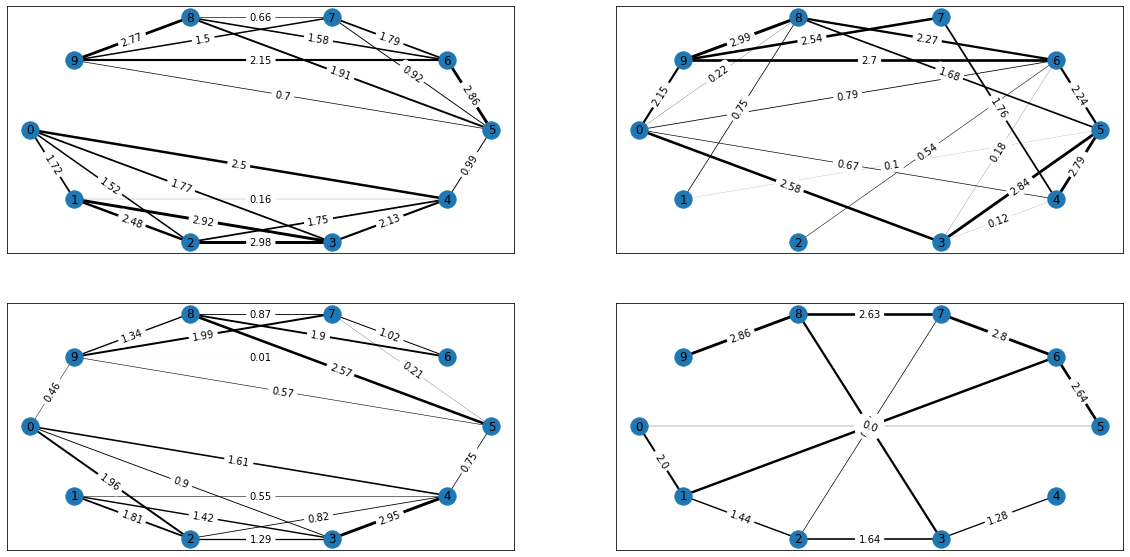

In [ ]:
import math

# n 개의 그래프 생성
for i in range(n_graph):
  graphs.append(
      create_graph(type=graph_types[i], num_nodes=num_nodes[i], weight=True)
  )

# subplot 으로 draw
col = math.ceil(n_graph / 2 )
plt.subplots(figsize=(20, 10))
for i in range(n_graph):
  plt.subplot(col , col, i+1)
  G = graphs[i]
  pos = nx.shell_layout(G)
  nx.draw_networkx_labels(G, pos)
  nx.draw_networkx_nodes(G, pos)
  nx.draw_networkx_edges(G, pos, width = [edge[2]["weight"] for edge in G.edges(data=True)])
  labels = nx.get_edge_attributes(G,'weight')
  nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()

In [ ]:
# qubits_s 에 그래프별 사용 큐빗 저장
for i in range(n_graph):
  qubits = []
  for j in range(num_nodes[i]):
    qubits.append(cirq.GridQubit(0, j))
  qubits_s.append(qubits)

# gamma beta 의 symbol 저장
gammas = []
betas = []
for i, p in enumerate(ps):
  gammas = [sympy.symbols(f'gamma_{i}_{j}') for j in range(p)]
  betas = [sympy.symbols(f'beta_{i}_{j}') for j in range(p)]
  gammas_s.append(gammas)
  betas_s.append(betas)

  print(gammas)
  print(betas)

[gamma_0_0, gamma_0_1, gamma_0_2]
[beta_0_0, beta_0_1, beta_0_2]
[gamma_1_0, gamma_1_1, gamma_1_2]
[beta_1_0, beta_1_1, beta_1_2]
[gamma_2_0, gamma_2_1, gamma_2_2]
[beta_2_0, beta_2_1, beta_2_2]
[gamma_3_0, gamma_3_1, gamma_3_2]
[beta_3_0, beta_3_1, beta_3_2]


In [ ]:
# 각 그래프에 대한 QAOA 회로 저장
qaoa_circuits = []
i = 0
for i in range(n_graph):
  qaoa_circuits.append(
    QAOA(graphs[i], qubits_s[i], ps[i], gammas_s[i], betas_s[i])
  )

-1.720*Z((0, 0))*Z((0, 1))-1.520*Z((0, 0))*Z((0, 2))-1.770*Z((0, 0))*Z((0, 3))-2.500*Z((0, 0))*Z((0, 4))-2.480*Z((0, 1))*Z((0, 2))-2.920*Z((0, 1))*Z((0, 3))-0.160*Z((0, 1))*Z((0, 4))-2.980*Z((0, 2))*Z((0, 3))-1.750*Z((0, 2))*Z((0, 4))-2.130*Z((0, 3))*Z((0, 4))-0.990*Z((0, 4))*Z((0, 5))-2.860*Z((0, 5))*Z((0, 6))-0.920*Z((0, 5))*Z((0, 7))-1.910*Z((0, 5))*Z((0, 8))-0.700*Z((0, 5))*Z((0, 9))-1.790*Z((0, 6))*Z((0, 7))-1.580*Z((0, 6))*Z((0, 8))-2.150*Z((0, 6))*Z((0, 9))-0.660*Z((0, 7))*Z((0, 8))-1.500*Z((0, 7))*Z((0, 9))-2.770*Z((0, 8))*Z((0, 9))+37.760*I
-2.580*Z((0, 0))*Z((0, 3))-0.670*Z((0, 0))*Z((0, 4))-0.790*Z((0, 0))*Z((0, 6))-0.220*Z((0, 0))*Z((0, 8))-2.150*Z((0, 0))*Z((0, 9))-0.100*Z((0, 1))*Z((0, 5))-0.750*Z((0, 1))*Z((0, 8))-0.540*Z((0, 2))*Z((0, 6))-0.120*Z((0, 3))*Z((0, 4))-2.840*Z((0, 3))*Z((0, 5))-0.180*Z((0, 3))*Z((0, 6))-2.790*Z((0, 4))*Z((0, 5))-1.760*Z((0, 4))*Z((0, 7))-2.240*Z((0, 5))*Z((0, 6))-1.680*Z((0, 5))*Z((0, 8))-2.270*Z((0, 6))*Z((0, 8))-2.700*Z((0, 6))*Z((0, 9))-2

In [ ]:
# gamma, beta 를 optimizer 로 최적화하여 gamma, beta 를 반환
def optimize_cirquit_parameters(circuit_index, optimizer_type = 'Adam', epochs = 1000, learning_rate = 0.01):
  optimizer = ''
  if optimizer_type == 'Adadelta' :
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = learning_rate)
  elif optimizer_type == 'Adagrad' :
    optimizer = tf.keras.optimizers.Adagrad(learning_rate = learning_rate)
  elif optimizer_type == 'Adam' :
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  elif optimizer_type == 'Nadam' :
    optimizer = tf.keras.optimizers.Nadam(learning_rate = learning_rate)
  elif optimizer_type == 'RMSprop' :
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate)
  elif optimizer_type == 'SGD' :
    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
  
  def loss(real, pred):
    return pred
 
  qaoa_circuit, op = qaoa_circuits[circuit_index]
  # - Optimal Parameter Search using Keras Model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
  parameter_layer = tfq.layers.PQC(qaoa_circuit, -op, repetitions=200)#[cirq.Z(cirq.GridQubit(0, i)) for i in range(6)] )
  model.add(parameter_layer)
  model.compile(loss=loss, optimizer = optimizer)
  dummy_input  = tfq.convert_to_tensor([cirq.Circuit()])
  dummy_output = np.array([[]])
  model.fit(dummy_input, dummy_output, epochs = epochs, verbose=0)
  return parameter_layer.get_weights()

In [ ]:
def run_circuit(idx, optimizer_type, epochs, learning_rate, filename, verbose = False):
  parameters = optimize_cirquit_parameters(idx, optimizer_type=optimizer_type, epochs = epochs, learning_rate = learning_rate)
  gammas = parameters[0][:ps[idx]]
  betas = parameters[0][ps[idx]:]

  # gammas = [-0.64161029, -1.02512235]
  # betas = [-1.00623778, -1.2293537 ]

  
  qaoa_circuit, _ = QAOA(graphs[idx], qubits_s[idx], ps[idx], gammas, betas)
  qaoa_circuit.append(cirq.Moment([cirq.measure(cirq.GridQubit(0,i), key=str(i)) for i in graphs[idx].nodes()]))
  simulator = cirq.Simulator()
  samples = simulator.sample(qaoa_circuit, repetitions=1000)
  print_result(graphs[idx], samples, idx, filename, verbose=verbose)
  brute_force(graphs[idx], idx, verbose=True)

In [ ]:
test_opts = ['Adadelta', 'Adagrad', 'Adam', 'Nadam', 'RMSprop', 'SGD']
epoch = 100 # hyper parameter 최적화. grid method
learning_rate = 0.1

for i in range(n_graph):
  for opt in test_opts:
    print(f'\ngraph: {i}, opt: {opt}')
    run_circuit(i, opt, epoch, learning_rate, f'csv/{i}_{opt}')


graph: 0, opt: Adadelta
-1.720*Z((0, 0))*Z((0, 1))-1.520*Z((0, 0))*Z((0, 2))-1.770*Z((0, 0))*Z((0, 3))-2.500*Z((0, 0))*Z((0, 4))-2.480*Z((0, 1))*Z((0, 2))-2.920*Z((0, 1))*Z((0, 3))-0.160*Z((0, 1))*Z((0, 4))-2.980*Z((0, 2))*Z((0, 3))-1.750*Z((0, 2))*Z((0, 4))-2.130*Z((0, 3))*Z((0, 4))-0.990*Z((0, 4))*Z((0, 5))-2.860*Z((0, 5))*Z((0, 6))-0.920*Z((0, 5))*Z((0, 7))-1.910*Z((0, 5))*Z((0, 8))-0.700*Z((0, 5))*Z((0, 9))-1.790*Z((0, 6))*Z((0, 7))-1.580*Z((0, 6))*Z((0, 8))-2.150*Z((0, 6))*Z((0, 9))-0.660*Z((0, 7))*Z((0, 8))-1.500*Z((0, 7))*Z((0, 9))-2.770*Z((0, 8))*Z((0, 9))+37.760*I
Expectation: 19.614249999999984
Approximation ratio : 0.73
MaxCut string : 0110101010, MaxCut value : 26.9

graph: 0, opt: Adagrad
-1.720*Z((0, 0))*Z((0, 1))-1.520*Z((0, 0))*Z((0, 2))-1.770*Z((0, 0))*Z((0, 3))-2.500*Z((0, 0))*Z((0, 4))-2.480*Z((0, 1))*Z((0, 2))-2.920*Z((0, 1))*Z((0, 3))-0.160*Z((0, 1))*Z((0, 4))-2.980*Z((0, 2))*Z((0, 3))-1.750*Z((0, 2))*Z((0, 4))-2.130*Z((0, 3))*Z((0, 4))-0.990*Z((0, 4))*Z((0, 5))-2

In [ ]:
# !zip -r /content/file.zip /content/csv
